In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

# Image类的图片模式

PIL 中的Image 类有9种不同的图片模式
分别为

在手绘化图片前，我们要将图片转化为灰色图像，进行图像的灰度化预处理。用PIL中的convert函数非常容易实现：

模式“L”即为灰色图像，它的每个像素用8个bit表示，0表示黑，255表示白，其他数字表示不同的灰度。

一般来说，图像灰度化的方法有四种：

在PIL中，这个从“RGB”模式到“L模式的转换公式为

这里，我以存储位置为/sdcard/1/img/sky.jpg为例:

In [2]:
img = Image.open('/sdcard/1/img/sky.jpg')
img

FileNotFoundError: [Errno 2] No such file or directory: '/sdcard/1/img/sky.jpg'

图片转换为数组

In [23]:
arr = np.asarray(img).astype('float')
type(arr)

numpy.ndarray

数组转换为图片

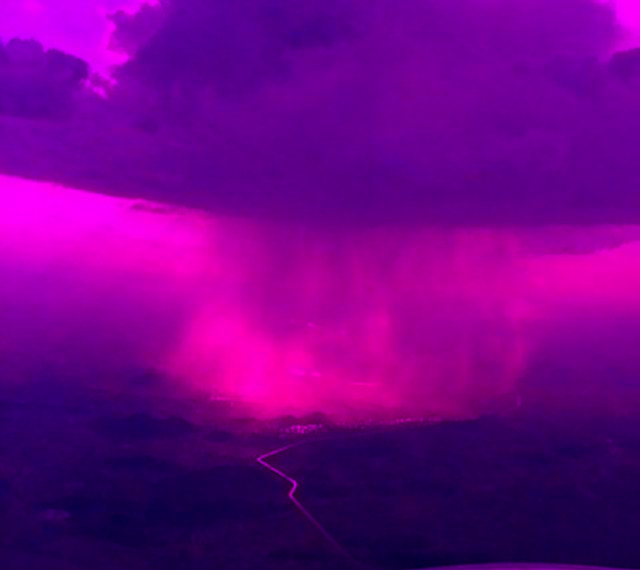

In [24]:
im = Image.fromarray(np.uint8(arr*[1, 0, 1]))
im

将图片转换为灰色图像

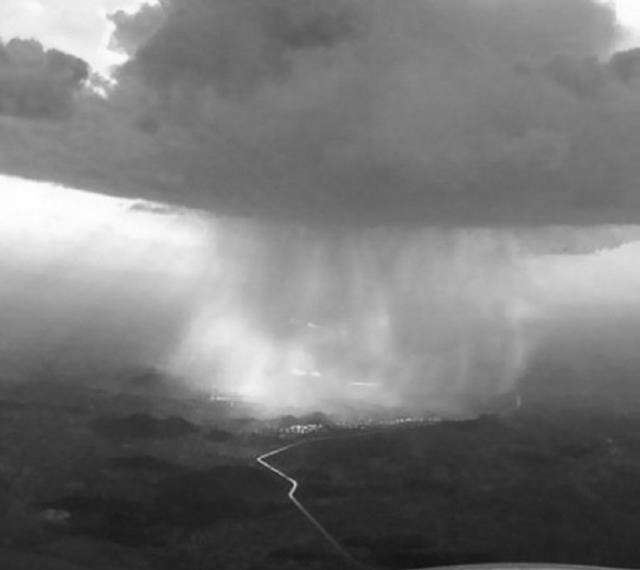

In [25]:
img.convert('L')

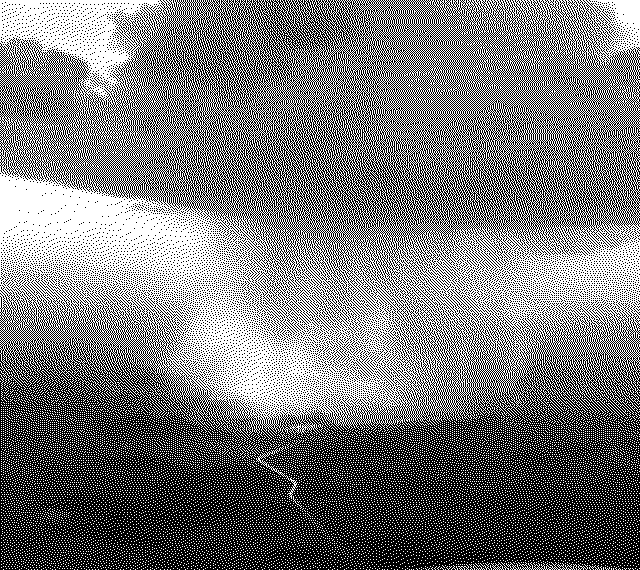

In [26]:
# 二值化
img.convert('1')

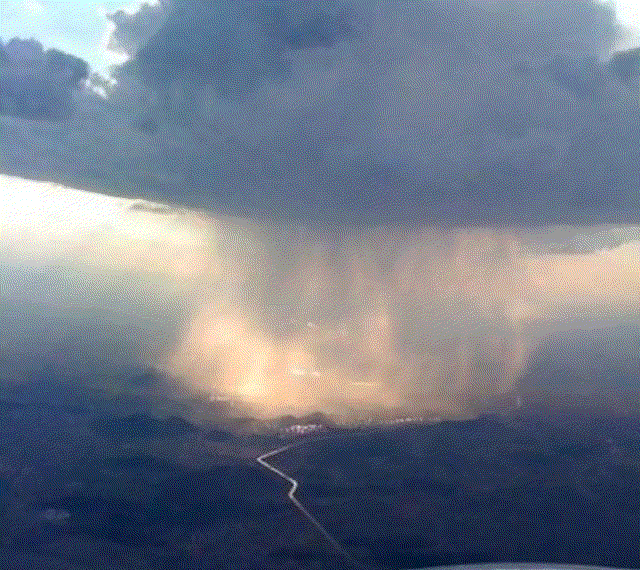

In [27]:
img.convert('P')

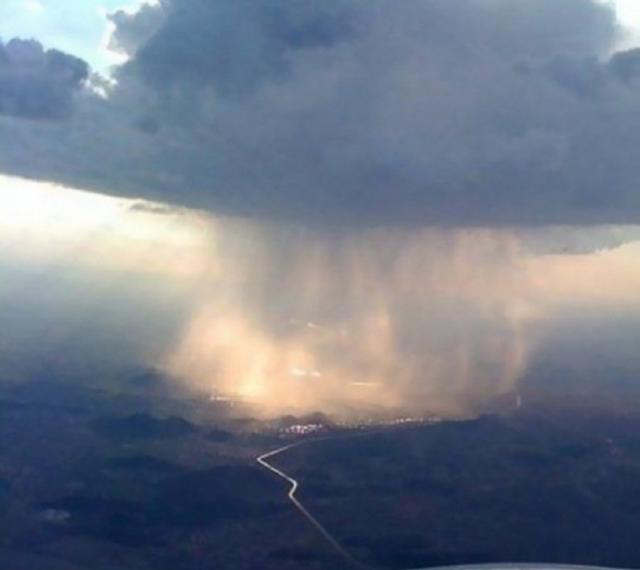

In [28]:
img.convert('RGBA')

# 数据的获取与存储

通过Numpy中的asarray函数将图片的灰度值以浮点型矩阵的形式存储起来，
再用gradient函数得出图片灰度值的梯度。

In [98]:
# 1，获取图像的数组值(即矩阵)
L = np.asarray(Image.open('/sdcard/1/img/oldman.jpg').convert('L')).astype('float')
grad = np.gradient(L)
# 2，获取x轴，y轴的梯度值
grad_x, grad_y = grad

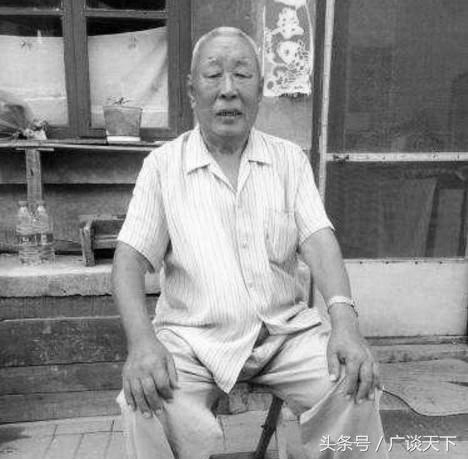

In [99]:
# 数组转图像
Image.fromarray(np.uint8(L))

我们观察一下L矩阵

In [100]:
L[:3]

array([[ 23.,  23.,  23., ...,  86.,  86.,  86.],
       [ 30.,  30.,  29., ...,  84.,  84.,  84.],
       [ 25.,  25.,  25., ...,  83.,  83.,  83.]])

In [101]:
L.ndim

2

In [102]:
L.shape

(459, 468)

可以看出L是一个534*401的二维浮点型矩阵，因此它的梯度grad里应该有两个数组矩阵，分别对应两层维度的梯度。

现取最外层维度梯度为x方向的梯度值grad_x，取第二层维度梯度值为y方向梯度值grad_y。

In [36]:
grad_x, grad_y = grad

这时我们已经取得了图像的梯度值，就可以通过改变像素的梯度值来改变图像的灰度变化，对图像进行重构了

# 图像的转换

我们先设一个深度值depth，取值范围为（0，100），然后利用深度调整x和y方向的梯度值。

我们使

In [113]:
# 3，设置深度值
depth = 30
# 4，修改x轴，y轴梯度值
grad_x = grad_x*depth/100
grad_y = grad_y*depth/100

A = np.sqrt(grad_x**2 + grad_y**2 + 1.)
uni_x = grad_x/A
uni_y = grad_y/A
uni_z = 1./A

因此我们需要通过改变depth，找到最符合人类视觉远近程度的深度值。

经过多次测试发现，当深度值为10左右时，即图像灰度梯度变为原来的10%左右时，画面最接近手绘化效果。（当然，对于不同的图片，这个最佳深度值不一定相同）

在本文中我们取depth=10

# 制造光源

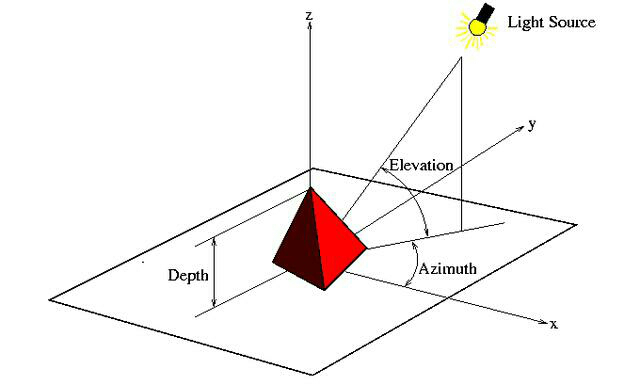

In [45]:
fm = Image.open('/sdcard/1/img/formula.jpg')
fm

如图，我们先假设一个光源位于图像斜上方，设俯视角为el，方位角为az，则单位光线在x,y,z方向上的投影长度分别为：

通过多次调整发现，当俯视角el=π/2.2, 方位角az=π/4时光照效果最好。（当然对于不同图像两个角度的选取不一定相同）

实现代码为：

In [165]:
# 5，设置俯视角el
el = np.pi/2.2
# 6，设置方位角az
az = np.pi/4.

# 7，计算光源对x轴,y轴，z轴的影响系数(dx, dy, dz)
dx = np.cos(el) * np.cos(az)
dy = np.cos(el) * np.sin(az)
dz = np.sin(el)
dx, dy, dz

(0.10063178720650688, 0.10063178720650687, 0.98982144188093268)

所以，此时图像的灰度值变为

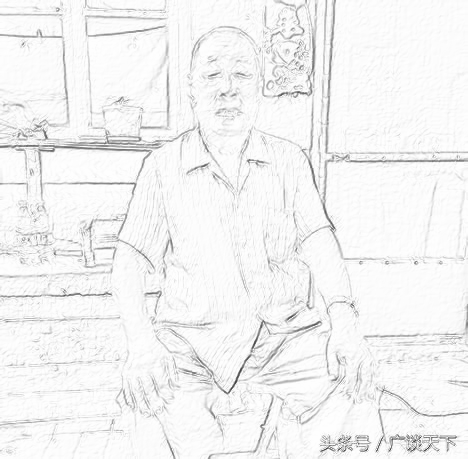

In [166]:
# 8，归一化()
gd = 255*(dx*uni_x + dy*uni_y + dz*uni_z)
# 9，剪裁，灰度值范围限制(0-255)
gd = gd.clip(0, 255)
# 10，将数组矩阵转换为图像
Image.fromarray(np.uint8(gd))

我们将这个过程叫做光源的归一化

重构图像

由于灰度值的选取范围为（0，255），为了避免数据越界，需要将生成的灰度值裁剪至0-255之间。

gd = gd.clip(0,255)

由新的灰度值重构图像

im = Image.fromarray(gd.astype('uint8'))

其中uint8是一种数据类型

u : 正数
int : 整数
8 : 8位信息，即最大值为255，最小值为0
这时图像的手绘化效果已经完成了

最后保存图像：

im.save('/sdcard/1/img/dogHD.jpg')

对于不同的图片可以通过修改深度值depth，光照的俯视角el和方位角az以获得最好的效果。

In [16]:
img.save('/sdcard/1/img/dogHD.jpg')

===============end==============

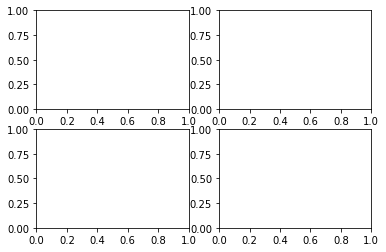

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

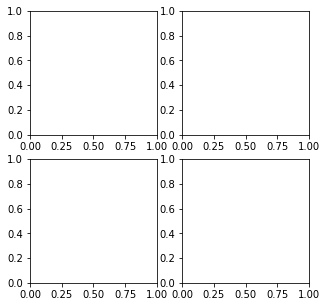

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0, 0] = img.convert('P')
axs[1, 0] = img.convert('L')
axs[0, 1] = img.convert('1')
axs[1, 1] = img.convert('RGBA')
plt.show()

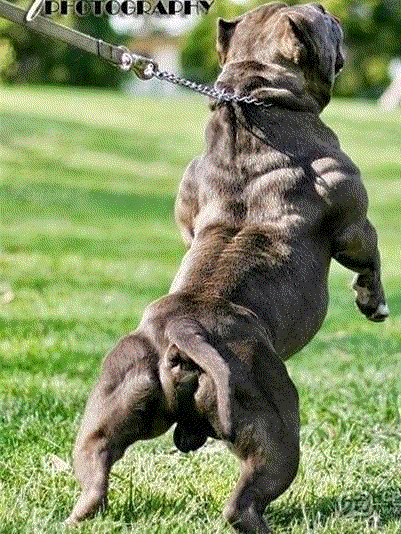

In [65]:
axs[0,0]

=====================================

# numpy和PIL对图像进行处理

In [1]:
from PIL import Image
import numpy as np
import sys 
import os
current_path = '/sdcard/1/img'
sys.path.append(current_path)

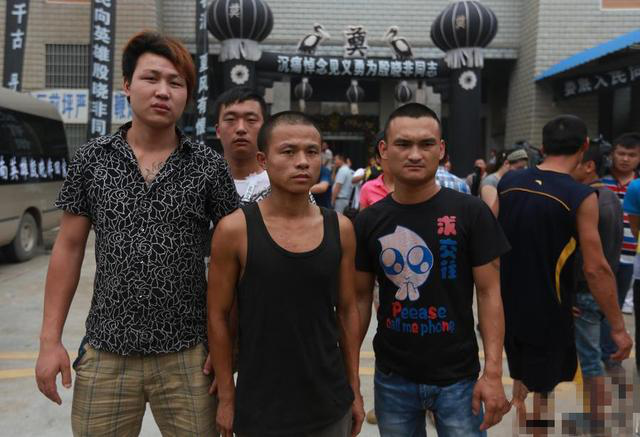

In [2]:
# 打开图像
im = Image.open('/sdcard/1/img/boy.jpg')
im

In [4]:
im.size

(640, 437)

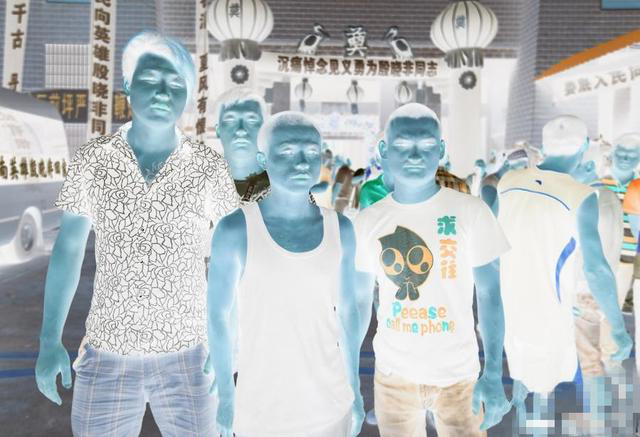

In [5]:
# 反相
a = np.array(im)
b = [255, 255, 255] - a
# 数组转图像
Image.fromarray(b.astype('uint8'))

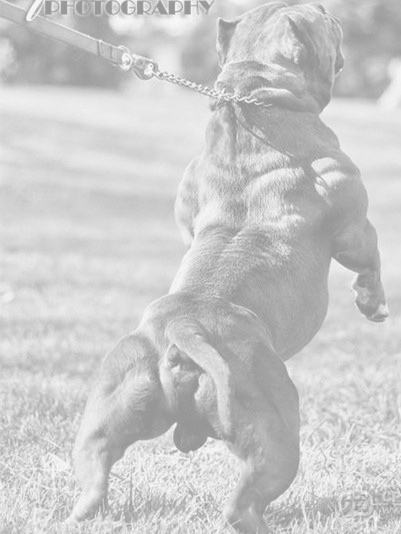

In [72]:
# 灰度，颜色变淡
a = np.array(Image.open('/sdcard/1/img/dog.jpg').convert('L'))
b = (100/255)*a + 150 # 区间压缩再增加
Image.fromarray(b.astype('uint8'))

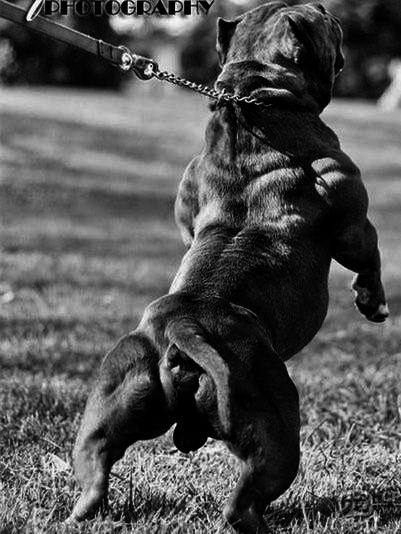

In [73]:
# 灰度，颜色加重
a = np.array(Image.open('/sdcard/1/img/dog.jpg').convert('L'))
b = 255 * (a/255)**2 # 像素的平方
Image.fromarray(b.astype('uint8'))


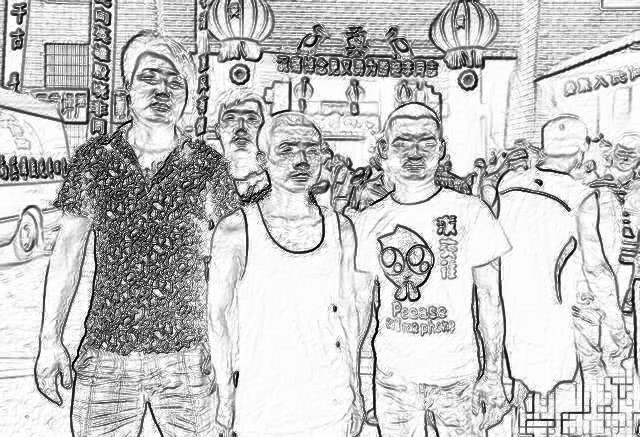

In [70]:
# 转手绘
a = np.array(Image.open('/sdcard/1/img/boy.jpg').convert('L')).astype('float')
depth = 10. # (0-100)
grad = np.gradient(a) # 取图像灰度的梯度值
grad_x, grad_y = grad # 分别取图像x轴y轴的梯度值
grad_x = grad_x*depth/100.
grad_y = grad_y*depth/100.

A = np.sqrt(grad_x**2 + grad_y**2 + 1.)
uni_x = grad_x/A
uni_y = grad_y/A
uni_z = 1./A

vec_el = np.pi/2.2 # 光源的俯视角度，弧度值
vec_az = np.pi/4.  # 光源的方位角度，弧度值
dx = np.cos(vec_el) * np.cos(vec_az) # 光源对x轴的影响
dy = np.cos(vec_el) * np.sin(vec_az) # 光源对y轴的影响
dz = np.sin(vec_el) # 光源对z轴的影响

b = 255*(dx*uni_x + dy*uni_y + dz*uni_z) # 光源归一化
# 数组值裁剪。范围限定在(0, 255)
b = b.clip(0, 255)
# 数组转图像
new_im = Image.fromarray(b.astype('uint8'))
# 图像保存本地
# new_im.save('/sdcard/1/img/dogSH.jpg')
new_im

In [20]:
grad_x
A
grad_x/A
dx, dy, dz
b.min()

0.0

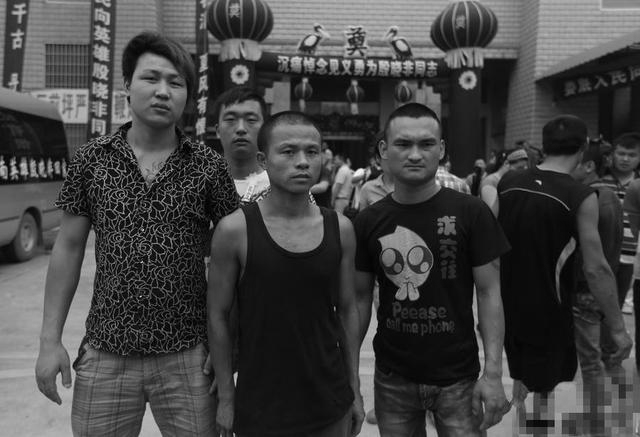

In [6]:
# 灰度处理
im_gray = im.convert('L')
im_gray

In [167]:
# 灰度图像转数组
arr = np.asarray(im_gray).astype('float')
type(arr)

numpy.ndarray